In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

import xarray as xr
import numpy as np
import gcsfs
import zarr
import xrft
from pyresample import image, geometry
import json
from matplotlib import pyplot as plt
%matplotlib inline

np.__version__

'1.17.0'

In [2]:
gcs = gcsfs.GCSFileSystem(token='anon')
ds_sst_full = xr.open_zarr(gcs.get_mapper('pangeo-data/llc4320_surface/SST'),
                           consolidated=True, chunks=False)
ds_sst_full

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    SST      (time, face, j, i) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [3]:
ds_sst_full.nbytes/1e9

8763.116685464

In [4]:
gcs = gcsfs.GCSFileSystem(token='anon')
ds_grid = xr.open_zarr(gcs.get_mapper('pangeo-data/llc4320_surface/grid'),
                           consolidated=True)
ds_grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k_p1: 2, time: 9030)
Coordinates:
    CS       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<shape=(2,), chunksize=(2,)>
    SN       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Z        float32 ...
    Zl       float32 ...
    Zp1      (k_p1) float32 dask.array<shape=(2,), chunksize=(2

In [5]:
# select random timestep and chunk
nt = np.random.randint(0, len(ds_sst_full.time))
ds_sst_faces = ds_sst_full.isel(time=nt).chunk({'face': 1})
ds_sst_faces

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    time     datetime64[ns] 2012-03-07T09:00:00
Data variables:
    SST      (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [6]:
# convert from 13-face format to quasi-latlon

from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
ds_sst_ll = faces_dataset_to_latlon(ds_sst_faces, metric_vector_pairs=[])
ds_sst_ll

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, j: 12960)
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
    time     datetime64[ns] 2012-03-07T09:00:00
Data variables:
    SST      (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>

In [7]:
ds_grid_ll = faces_dataset_to_latlon(ds_grid)
ds_grid_ll

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_p1: 2, time: 9030)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * k_p1     (k_p1) int64 0 1
    CS       (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>
    Depth    (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>
    PHrefC   float32 15.4017
    PHrefF   (k_p1) float32 dask.array<shape=(2,), chunksize=(2,)>
    SN       (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>
    XC       (j, i) float32 dask.array<shape=(12960, 17280), ch

In [8]:
# add lon and lat to sst dataset
ds_sst_ll.coords['lon'] = ds_grid_ll.XC.reset_coords(drop=True)
ds_sst_ll.coords['lat'] = ds_grid_ll.YC.reset_coords(drop=True)
ds_sst_ll

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, j: 12960)
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
    time     datetime64[ns] 2012-03-07T09:00:00
    lon      (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>
    lat      (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>
Data variables:
    SST      (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>

In [9]:
# total size of dataset in MB
ds_sst_ll.nbytes/1e6

2687.627632

In [10]:
with open('land_free_regions_llc4320.json') as f:
    d = json.load(f)
    regions = xr.Dataset.from_dict(d)
regions

<xarray.Dataset>
Dimensions:  (point: 321)
Dimensions without coordinates: point
Data variables:
    lon      (point) float64 -32.52 -55.76 -166.8 ... -32.72 -12.24 0.4759
    lat      (point) float64 -74.01 -73.79 -73.56 -73.28 ... 62.82 68.88 69.47
    j        (point) int64 2190 2190 2190 2190 2190 ... 11370 11910 12450 12450
    i        (point) int64 30 10290 10830 11370 11910 ... 16230 30 1110 1650
Attributes:
    region_size:  540

In [12]:
# select a random patch of ocean

region = regions.sel(point=100)

size_j, size_i = regions.region_size, regions.region_size
i_start = region.i.values.item()
j_start = region.j.values.item()
ds_patch = ds_sst_ll.isel(i=slice(i_start, i_start + size_i),
                          j=slice(j_start, j_start + size_j))
ds_patch.load()

<xarray.Dataset>
Dimensions:  (face: 13, i: 540, j: 540)
Coordinates:
  * j        (j) int64 4350 4351 4352 4353 4354 ... 4885 4886 4887 4888 4889
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 12990 12991 12992 12993 12994 ... 13526 13527 13528 13529
    time     datetime64[ns] 2012-03-07T09:00:00
    lon      (j, i) float32 -127.364586 -127.34375 ... -116.15625 -116.135414
    lat      (j, i) float32 -56.668156 -56.668156 ... -50.31499 -50.31499
Data variables:
    SST      (j, i) float32 4.1144753 4.155275 4.1922054 ... 7.4582787 7.4570017

In [13]:
len(ds_patch.i)

540

In [14]:
region

<xarray.Dataset>
Dimensions:  ()
Data variables:
    lon      float64 -122.4
    lat      float64 -53.91
    j        int64 4350
    i        int64 12990
Attributes:
    region_size:  540

Text(0.5, 1.0, '-122.37500762939453, -53.910709381103516')

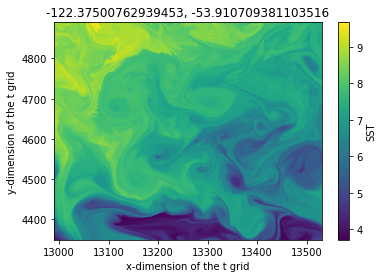

In [15]:
# plot in "raw" grid coordinates
ds_patch.SST.plot()
plt.title(f'{region.lon.values}, {region.lat.values}')

In [16]:
def target_area_def(ds_patch):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(i=size_i//2, j=size_j//2)
    center_lon, center_lat = center_point.lon.values.item(), center_point.lat.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512
    height = 512

    # 512 x 512 km
    area_extent = (-256000., -256000., 256000., 256000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def


def image_to_dataset(im):
    """Wrap pyresample image in xarray dataset."""
    geo_def = im.geo_def
    units = geo_def.proj_dict['units']
    lons, lats =  geo_def.get_lonlats()
    ds_resampled = xr.DataArray(im.image_data, dims=['y', 'x'],
                                coords={'x': ('x', geo_def.projection_x_coords, {'units':  units}),
                                        'y': ('x', geo_def.projection_y_coords, {'units':  units}),
                                        'lon': (['y', 'x'], lons),
                                        'lat': (['y', 'x'], lats)
                                       }, name='SST').to_dataset()
    ds_resampled.coords['projection'] = ('projection', [1], geo_def.proj_dict)
    
    # what metadata to save? this seems relevant
    # http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#grid-mappings-and-projections
    return ds_resampled

def resample_patch(ds_patch):
    """Resample a patch of ocean."""
    grid_def = geometry.GridDefinition(lons=ds_patch.lon.values, lats=ds_patch.lat.values)
    data = ds_patch.SST.to_masked_array()
    im = image.ImageContainerBilinear(data, grid_def,
                                      radius_of_influence=4000., fill_value=None)
    
    area_def = target_area_def(ds_patch)
    im_resampled = im.resample(area_def)
    return image_to_dataset(im_resampled)

In [17]:
da_resampled = resample_patch(ds_patch)
da_resampled

<xarray.Dataset>
Dimensions:     (projection: 1, x: 512, y: 512)
Coordinates:
  * x           (x) float64 -2.555e+05 -2.545e+05 ... 2.545e+05 2.555e+05
    y           (x) float64 2.555e+05 2.545e+05 ... -2.545e+05 -2.555e+05
    lon         (y, x) float64 -125.4 -125.4 -125.4 ... -117.7 -117.7 -117.7
    lat         (y, x) float64 -51.23 -51.23 -51.23 ... -55.82 -55.82 -55.82
  * projection  (projection) int64 1
Data variables:
    SST         (y, x) float64 8.386 8.39 8.392 8.392 ... 5.858 5.803 5.722

/srv/conda/envs/notebook/lib/python3.7/site-packages/xrft/xrft.py:589: RuntimeWarning: invalid value encountered in true_divide
  kr = np.bincount(kidx, weights=K.ravel()) / area
/srv/conda/envs/notebook/lib/python3.7/site-packages/xrft/xrft.py:599: RuntimeWarning: invalid value encountered in true_divide
  / area) * kr


Text(0.5, 1.0, 'Isotropic Wavenumber Specrum')

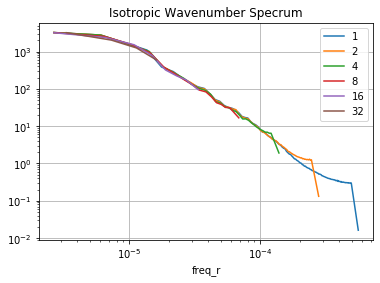

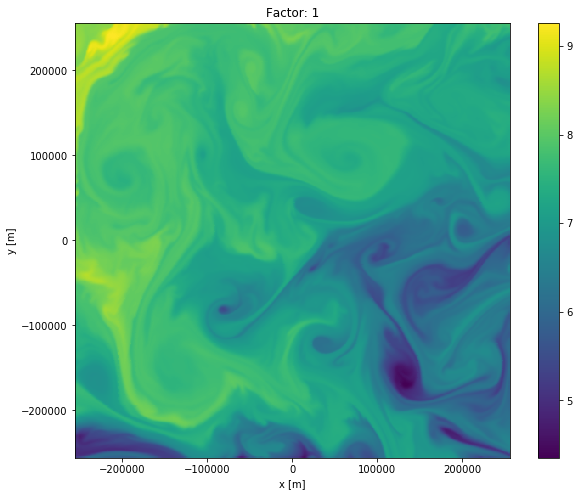

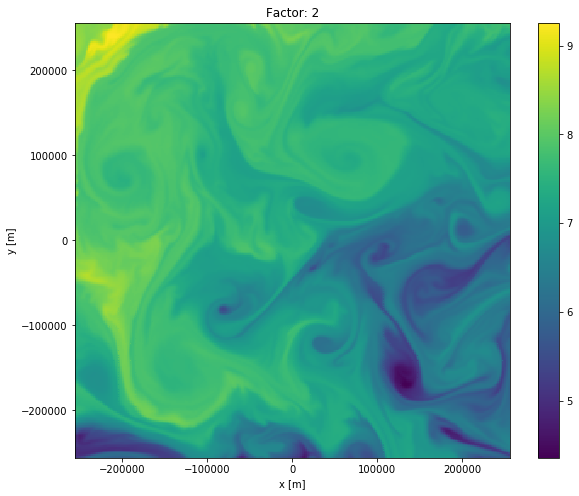

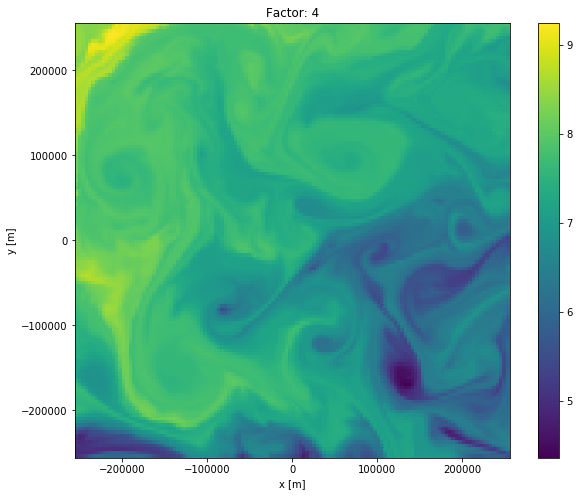

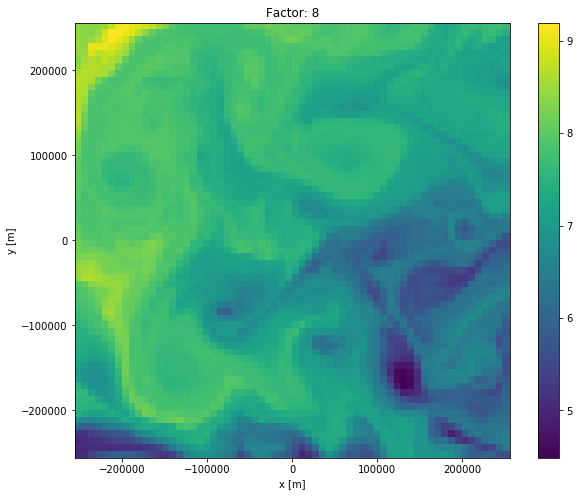

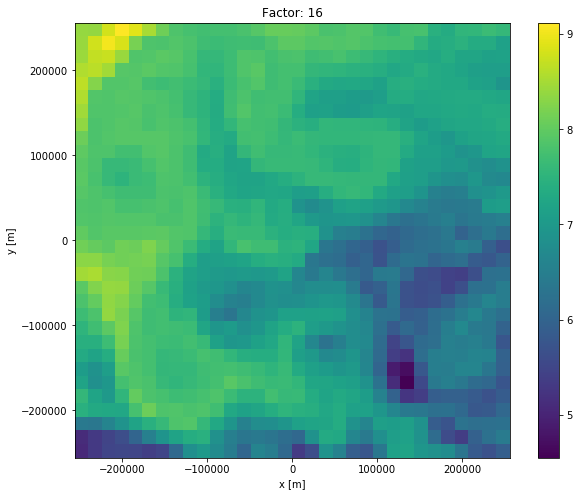

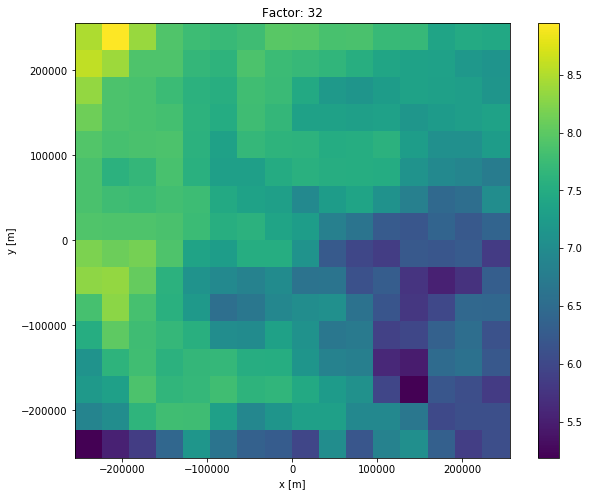

In [19]:
from matplotlib import pyplot as plt

fig_spec, ax_spec = plt.subplots()

for factor in [1, 2, 4, 8, 16, 32]:
    fig, ax1= plt.subplots(figsize=(10, 8))
    da_coarse = da_resampled.SST.coarsen(x=factor, y=factor).mean()
    da_coarse.plot(ax=ax1)
    ax1.set_title(f'Factor: {factor}')
    ax1.set_aspect('equal')
    
    spec = abs(xrft.isotropic_powerspectrum(da_coarse, detrend='linear', dim=['x', 'y']))
    spec.plot(ax=ax_spec, yscale='log', xscale='log', label=f'{factor}')
    
ax_spec.legend()
ax_spec.grid()
ax_spec.set_title('Isotropic Wavenumber Specrum')